In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from numpy import mean
from numpy import std
from numpy import absolute

data = pd.read_csv('titanic_train.csv')
data.head()

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1216,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1
1,699,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0
2,1267,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0
3,449,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1
4,576,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0


In [2]:
#data.info()

In [3]:
#data.isnull().sum()

In [4]:
data.describe()

,passenger_id,pclass,age,sibsp,parch,fare,body,survived
count,850.000000,850.00000,676.000000,850.000000,850.000000,849.000000,73.000000,850.000000
mean,662.816471,2.32000,29.519847,0.522353,0.382353,34.012701,165.821918,0.368235
std,380.751936,0.83853,14.562243,1.112132,0.879511,53.705779,99.068487,0.482610
min,1.000000,1.00000,0.166700,0.000000,0.000000,0.000000,4.000000,0.000000
25%,332.250000,2.00000,20.000000,0.000000,0.000000,7.895800,75.000000,0.000000
50%,676.500000,3.00000,28.000000,0.000000,0.000000,14.108300,166.000000,0.000000
75%,992.250000,3.00000,37.000000,1.000000,0.000000,31.000000,260.000000,1.000000
max,1307.000000,3.00000,80.000000,8.000000,9.000000,512.329200,328.000000,1.000000


##### From above
Notice the spread between 75% percentile and the max on data['fare']

In [5]:
data['fare'].max()

512.3292

Text(0, 0.5, 'No. of Passengers')

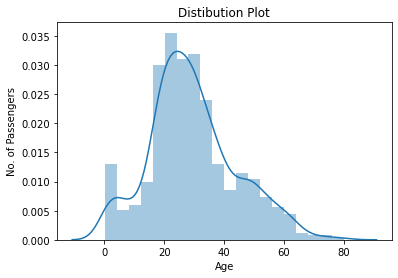

In [6]:
figure = data.age
figure = sns.distplot(figure, bins=20)
figure.set_title('Distibution Plot')
figure.set_xlabel('Age')
figure.set_ylabel('No. of Passengers')

<AxesSubplot:xlabel='age'>

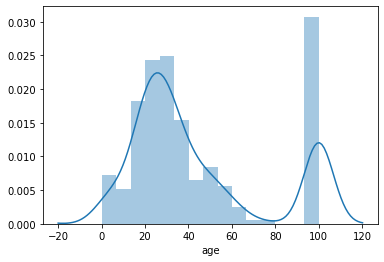

In [7]:
# Creating a fake outlier
sns.distplot(data['age'].fillna(100))

Text(0, 0.5, 'No. of Passengers')

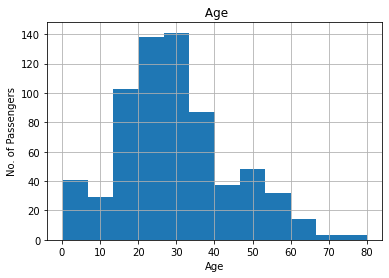

In [8]:
#Gaussian Distribution plot
figure = data.age.hist(bins=12)
figure.set_title(' Age')
figure.set_xlabel('Age')
figure.set_ylabel("No. of Passengers")


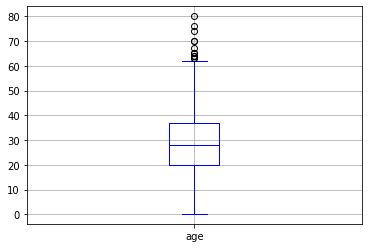

In [9]:
# Boxplot of age
figure = data.boxplot(column='age', color= 'blue')

In [10]:
data['age'].describe().T

count    676.000000
mean      29.519847
std       14.562243
min        0.166700
25%       20.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: age, dtype: float64

#### For Gausian Distribution data

In [11]:
##### Assuming that age follows a Gaussian Distribution we will calculat the baundaries 
upper_boundary = data['age'].mean() + 3 * data['age'].std()
lower_boundary = data['age'].mean() - 3 * data['age'].std()
print(lower_boundary), print(upper_boundary), print(data['age'].mean())

-14.166883113027474
73.20657749172571
29.519847189349115


(None, None, None)

#### For Skewed Data

Text(0, 0.5, 'No. of Passengers')

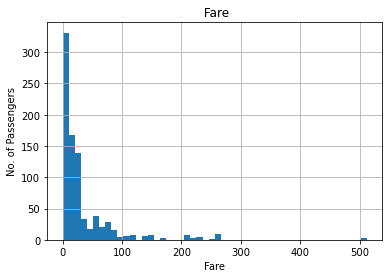

In [12]:
### Graphical representation of the fare column
figure = data.fare.hist(bins=50)
figure.set_title(' Fare')
figure.set_xlabel('Fare')
figure.set_ylabel("No. of Passengers")

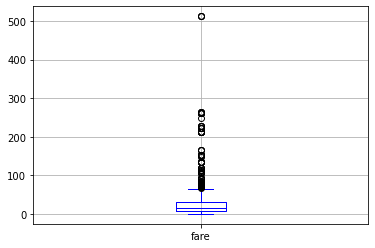

In [13]:
#### Graphical represenation of the fare column?
figure = data.boxplot(column='fare', color= 'blue')

In [14]:
# determine the distribution of fare using describe method
data.fare.describe()  ### # Why is this describe has a MAX of 512 while the DataFrame describe has a MAX of 106 on fare????

count    849.000000
mean      34.012701
std       53.705779
min        0.000000
25%        7.895800
50%       14.108300
75%       31.000000
max      512.329200
Name: fare, dtype: float64

In [15]:
### Computing the interquantile range to calculat the boundaries
#IQR = The difference between the 75percentile and the 25percentile

IQR = data.fare.quantile(.75) - data.fare.quantile(0.25)

#### Finding Boundaries for Non-Extreme Outliers

In [16]:
# for non-extreme outliers

lower_bridge = data.fare.quantile(0.25) - (IQR * 1.5)
upper_bridge = data.fare.quantile(0.75) + (IQR * 1.5)
print(lower_bridge), print(upper_bridge)

-26.7605
65.6563


(None, None)

#### Finding Boundaries for Extreme Outliers

In [17]:
#### for extreme outliers

lower_bridge = data.age.quantile(0.25) - (IQR * 3)
upper_bridge = data.age.quantile(0.75) + (IQR * 3)
print(lower_bridge), print(upper_bridge)

-49.3126
106.3126


(None, None)

#### Feature Engineering 

In the code below, we are going to try to normalize the data by:
1. Apply the outlier limit on the age column (limit = 73)
2. Apply the outlier limit on the fare colum (limit = 106)

In [18]:
### Eliminating outliers in data.age & data.fare
data = data.copy()
data.loc[data['age']>=73, 'age']==73 
data.loc[data['fare']>=106, 'fare']=106 #.merge([data['fare']>=106, 'fare']==106], left_on='survived',right_on='survived')
data.head()

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1216,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1
1,699,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0
2,1267,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0
3,449,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1
4,576,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0


In [19]:
## Eliminating outliers in data.fare
data=data.copy()
data.loc[data['fare']>=106, 'fare']=106 
data.head()

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1216,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1
1,699,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0
2,1267,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0
3,449,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1
4,576,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0


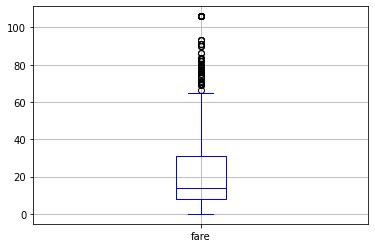

In [20]:
#### What if you have another dataset?
figure = data.boxplot(column='fare', color= 'blue')

<AxesSubplot:xlabel='fare'>

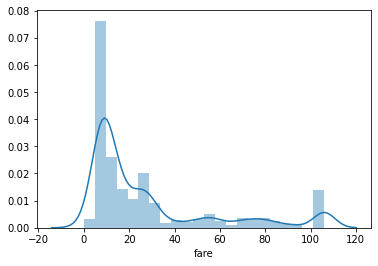

In [21]:
#data = data['fare']
sns.distplot(data['fare'])

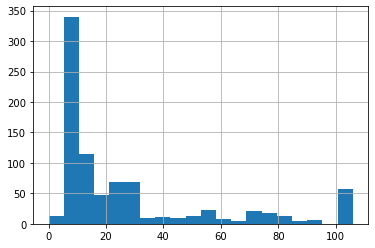

In [22]:
figure = data['fare'].hist(bins=20)

### Machine Learning

In this section we will do the following
1. logically select the data columns we will use for our prediction by using pandas loc method
2. use select_dtypes to logically separate the numerical from categorical columns
3. use sklearn preprocessing technics to prepare data before it's being fitted


In [23]:
# Selecting new features for the dataframe
#data = data.loc[:,['pclass','sex','age','sibsp','parch','fare','embarked', 'survived']]
data = data.loc[data['age'].notna() & data['embarked'].notna()& data['fare'].notna(),['pclass','sex','age','sibsp','parch','fare','embarked','survived']]
data.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
1,3,male,38.0,0,0,8.6625,S,0
2,3,female,30.0,1,1,24.1500,S,0
3,2,female,54.0,1,3,23.0000,S,1
4,2,male,40.0,0,0,13.0000,S,0
5,3,male,28.0,0,0,22.5250,S,0


In [24]:
data.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

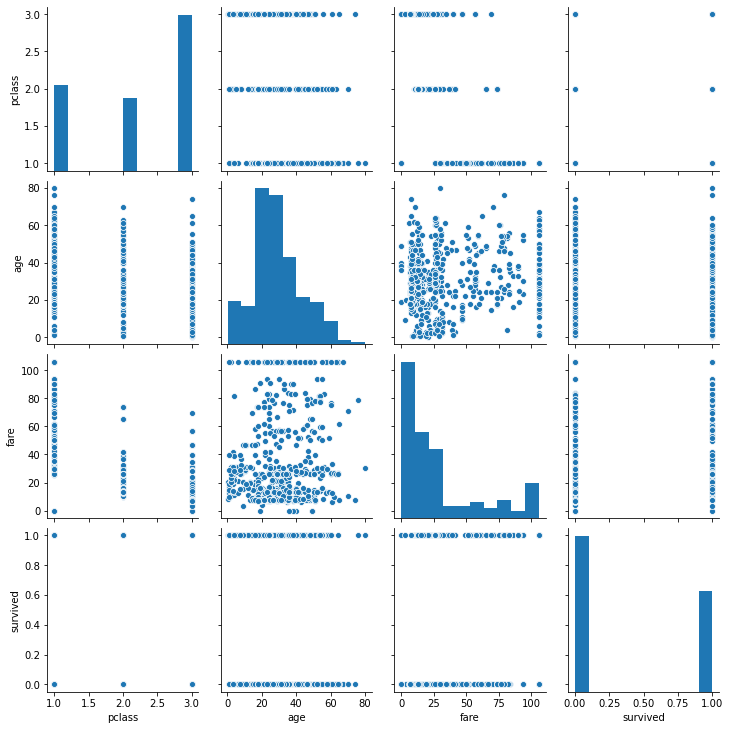

In [25]:
# vizualizing the data to find correlation
sns.pairplot(data[['pclass','age','fare','survived']], kind ='scatter')

##### Splitting data for machine learning

In [26]:
# Split the data from train_test
X = data[['pclass','sex','age','sibsp','parch','fare','embarked']]
y = data['survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state =0)

In [27]:
# determine categorical and numerical features
cat_cols= data.select_dtypes(include = 'object').columns
num_cols= data.select_dtypes(include = ['int64','float64']).columns
#sel_cols = [5,6] #data[['age','fare']]  sel_cols = [data.columns.values[5:7]]
print(cat_cols), print(num_cols) #print(sel_cols)

Index(['sex', 'embarked'], dtype='object')
Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived'], dtype='object')


(None, None)

In [28]:
# define the data preparation for the columns
col_trans = [('cat', OneHotEncoder(), cat_cols)]#, ('num', StandardScaler(), sel_cols )]
col_transformer =ColumnTransformer(transformers = col_trans, remainder = 'passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(),
                                 Index(['sex', 'embarked'], dtype='object'))])

In [29]:
# define the models
classifier_1 = LogisticRegression(solver = 'liblinear') #liblinear
classifier_2 = RandomForestClassifier()
classifier_3 = XGBClassifier(seed = 45)
classifier_4 = KNeighborsClassifier(n_neighbors=3)
classifier_5 = SVC(kernel='linear')

In [30]:
# define the data preperation and modeling pipeline
from sklearn.pipeline import Pipeline

pipe_1 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_1)])
pipe_2 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_2)])
pipe_3 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_3)])
pipe_4 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_4)])
pipe_5 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_5)])

In [31]:
# Chaining the pipelines together
pipelines = [pipe_1, pipe_2, pipe_3, pipe_4, pipe_5]

##### Determining the the best of all

In [32]:
# description of the results
best_accuracy = 0.0
best_classifier = 0
best_pipeline=''

In [33]:
# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [34]:
# Dictionary of pipelines and classifier types fo ease of reference
pipe_dict = {0:'LogisticRegression', 1:'RandomForestClassifier', 2:'XGBClassifier', 3:'KNeighborsClassifier', 4: 'SVC'}


In [36]:
# determining the Accuracy
for i, model in enumerate(pipelines):
    #print('{} Test Accuracy: {}'.format(pipe_dict[i], model.score(X_valid, y_valid)))
    print(f'The model {pipe_dict[i]} has a Test Acuracy of: {model.score(X_valid, y_valid)}')

The model LogisticRegression has a Test Acuracy of: 0.729064039408867
The model RandomForestClassifier has a Test Acuracy of: 0.7684729064039408
The model XGBClassifier has a Test Acuracy of: 0.7536945812807881
The model KNeighborsClassifier has a Test Acuracy of: 0.6009852216748769
The model SVC has a Test Acuracy of: 0.7142857142857143


###### Best model 

In [37]:
# using enumerate to determine the best model based on the accuracy score
for i, model in enumerate(pipelines):
    if model.score(X_valid, y_valid) > best_accuracy:
        best_accuracy = model.score(X_valid, y_valid)
        best_pipeline = model
        best_classifier = i
print('Classifier with best accuracy: {}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy: RandomForestClassifier


### Intruducing Test Data

In [38]:
# using the provided test data to test predict the outcome
X_test= pd.read_csv('titanic_test.csv')
#X_test

In [39]:
#X_test.isnull().sum()

In [40]:
# Selecting new features for the dataframe
X_test = X_test.loc[X_test['age'].notna() & X_test['embarked'].notna(),['pclass','sex','age','sibsp','parch','fare', 'embarked']]
#X_test.head()

In [41]:
'''If you're using a pipeline that encapsulates your preprocessing and model building, 
the only thing you need to do a with a new test set is to run the predict method with the fitted pipeline. 
Does that help? -- Kevin Markham'''

# XGboost Classifier
pipe_3 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_3)])
y_pred_test = pipe_3.predict(X_test)
y_pred_test

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [42]:
# RandomForestClassifier
pipe_2 = Pipeline(steps=[('ct', col_transformer), ('model', classifier_2)])
y_pred_test = pipe_2.predict(X_test)
y_pred_test

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,